# A Simple Implentation of Random Forest Regressor with Hyperparameter Tuning On Chase Bank Deposit Dataset 2010-2016

### The aim is to predict next years deposits using data on past year deposits as well as location of the branch

## https://www.kaggle.com/chasebank/bank-deposits

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn import metrics
%matplotlib inline

In [4]:
#reading the data
df = pd.read_csv(r"database.csv"
                     , low_memory=False,parse_dates=["Established Date","Acquired Date"])

In [5]:
df.head()

,Institution Name,Main Office,Branch Name,Branch Number,Established Date,Acquired Date,Street Address,City,County,State,Zipcode,Latitude,Longitude,2010 Deposits,2011 Deposits,2012 Deposits,2013 Deposits,2014 Deposits,2015 Deposits,2016 Deposits
0,JPMorgan Chase Bank,1,JPMorgan Chase Bank Main Office,0,1824-01-01,NaT,1111 Polaris Parkway,Columbus,Delaware,OH,43240,40.14453,-82.99115,633131000.0,743268000.0,832455000.0,916543000.0,1.032549e+09,1.069425e+09,1155185000
1,JPMorgan Chase Bank,0,Vernon Hills Scarsdale Branch,2,1961-03-20,NaT,676 White Plains Road,Scarsdale,Westchester,NY,10583,40.97008,-73.80670,293229.0,310791.0,325742.0,327930.0,3.277920e+05,3.414750e+05,381558
2,JPMorgan Chase Bank,0,Great Neck Northern Boulevard Branch,3,1963-09-09,NaT,410 Northern Boulevard,Great Neck,Nassau,NY,11021,40.77944,-73.72240,191011.0,206933.0,216439.0,237983.0,2.341830e+05,2.624550e+05,278940
3,JPMorgan Chase Bank,0,North Hartsdale Branch,4,1966-02-19,NaT,353 North Central Avenue,Hartsdale,Westchester,NY,10530,41.02654,-73.79168,87110.0,88367.0,93163.0,109659.0,1.119850e+05,1.167720e+05,140233
4,JPMorgan Chase Bank,0,Lawrence Rockaway Branch,5,1965-01-16,NaT,335 Rockaway Turnpike,Lawrence,Nassau,NY,11559,40.62715,-73.73675,172608.0,172749.0,189413.0,198445.0,2.051980e+05,2.232000e+05,235594


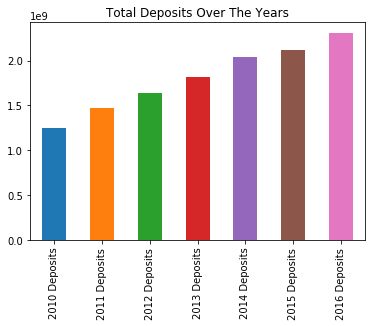

In [9]:
#Plotting the total deposits from 2010 to 2016
df_plot = df[['2010 Deposits','2011 Deposits','2012 Deposits','2013 Deposits','2014 Deposits','2015 Deposits','2016 Deposits']]
df_plot.sum().plot.bar(title = 'Total Deposits Over The Years')

In [10]:
#Creating dummies for State and Joining it with the Original Data
df_dummies = pd.get_dummies(df['State'])
df = pd.merge(df, df_dummies, left_index=True, right_index=True)

In [16]:
#defining target and predictor variables
#imputing 0s with 10s so as to avoid inf errors during testing  
X=df[[i for i in df.columns if (('Deposits' in i) and ('2016' not in i))or ('State_' in i)]]
y=df['2016 Deposits']
X.head()
X.replace(0,10, inplace=True)
y.replace(0, 10, inplace=True)
X.fillna(0, inplace=True)

C:\Users\Ado\Anaconda3\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
C:\Users\Ado\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [17]:
#test train split
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test= train_test_split(X,y,test_size=0.3,shuffle=True)
#fitting a random forest model
model = RandomForestRegressor(n_estimators=250, max_depth=10, min_samples_split=10, n_jobs=-1)
model.fit(X_train, Y_train)
#predicting on the test data
Y_hat = model.predict(X_test)
#creating a dataframe with actual and predicted values
Y_test = pd.DataFrame(Y_test)
Y_test['Y_hat'] = Y_hat
#Calculating Percentage Error for each observation
Y_test['PE'] = (abs((Y_test['2016 Deposits'] - Y_test['Y_hat']))/Y_test['2016 Deposits'])

In [18]:
#calculating which deciles of percentage errors
Y_test['PE_decile'] = pd.qcut(Y_test['PE'], 10, labels = list(range(1,11)))

In [19]:
#seeing how percentage error is distributed
Y_test.groupby('PE_decile').agg({'PE':'mean'})

,PE
PE_decile,
1,0.005179
2,0.015141
3,0.026289
4,0.039560
5,0.052890
6,0.069313
7,0.092142
8,0.122846
9,0.188316


In [44]:
Median_Percentage_Error = Y_test['PE'].median()
print("Median Percentage Error is : " +  str(round(Median_Percentage_Error*100,2)) + '%')

Median Percentage Error is : 5.83%


## Hyper Paramter Tuning

In [23]:
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

#initializing the regressor
clf = RandomForestRegressor(random_state=0)

#creating parameter
parameters = {'n_estimators': [50,100,150],
               'max_features': ['auto'],
               'max_depth': [5,10,20],
               'min_samples_split': [2,5,10],
               'min_samples_leaf': [2,4,5],
               'bootstrap': [True]}

In [38]:
#making a scorer using MSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [40]:
#creating and fitting grid search object
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)
grid_fit = grid_obj.fit(X_train,Y_train)

In [42]:
#selecting the best model
best_clf = grid_fit.best_estimator_
#predicting on the test data
Y_hat_new = best_clf.predict(X_test)
#creating a dataframe with actual and predicted values
Y_test_new = pd.DataFrame(Y_test)
Y_test_new['Y_hat'] = Y_hat_new
#Calculating Percentage Error for each observation
Y_test_new['PE'] = (abs((Y_test_new['2016 Deposits'] - Y_test_new['Y_hat']))/Y_test_new['2016 Deposits'])
#calculating which deciles of percentage errors
Y_test_new['PE_decile'] = pd.qcut(Y_test_new['PE'], 10, labels = list(range(1,11)))
#seeing how percentage error is distributed
Y_test_new.groupby('PE_decile').agg({'PE':'mean'})
#marginal improvement in the result when it comes to the bottom 9 deciles but significant improvement in the last decile
#last decile is still way off, it is because of cold start problem as many braches opened recently and there is isn't sufficient data for them

,PE
PE_decile,
1,0.005027
2,0.014498
3,0.025904
4,0.039228
5,0.051624
6,0.067842
7,0.091083
8,0.120878
9,0.181064


In [50]:
#new MdApe is the same as the old one
Median_Percentage_Error = Y_test_new['PE'].median()
print("Median Percentage Error is : " +  str(round(Median_Percentage_Error*100,2)) + '%')

Median Percentage Error is : 5.83%
